In [1]:
import pandas as pd
import spacy
from cytoolz import identity
# from spacy.lemmatizer import Lemmatizer

In [2]:
%%time

df, _ = pd.read_msgpack('https://bit.ly/2UcyWOV')

Wall time: 30.6 s


In [19]:
nlp = spacy.load('en', disable=['ner', 'parser'])

Tokenize from Headline

In [4]:
%%time

def tokenize(text):
    return [tok.orth_ for tok in nlp.tokenizer(text)]
df['tokens'] = df['headline'].apply(tokenize)

Wall time: 7.98 s


In [5]:
df

,date,headline,itemid,text,sports,politics,tokens
1829,1997-01-22,Libya says plane flew to Ghana despite U.N. ban.,325883,Libya said on Wednesday a Libyan plane had flo...,False,False,"[Libya, says, plane, flew, to, Ghana, despite,..."
1050,1997-07-06,Dirty laundry to be aired at Senate hearings.,709460,A Senate investigation into political fund-rai...,False,True,"[Dirty, laundry, to, be, aired, at, Senate, he..."
407,1996-09-08,"BA denies report of 10,000 imminent job cuts.",39622,British Airways (BA) denied on Monday a newspa...,False,False,"[BA, denies, report, of, 10,000, imminent, job..."
376,1996-12-30,Gulf states could reinstate Israel boycott - p...,281305,Gulf Arab states could reinstate a boycott the...,False,False,"[Gulf, states, could, reinstate, Israel, boyco..."
728,1997-03-06,Volvo Belgian plant to hold Friday stoppage.,425537,Swedish vehicle maker AB Volvo said on Thursda...,False,False,"[Volvo, Belgian, plant, to, hold, Friday, stop..."
1267,1997-07-08,INSTANT VIEW - German unemployment data for June.,715078,Following are economists' reactions to a repor...,False,False,"[INSTANT, VIEW, -, German, unemployment, data,..."
1222,1997-06-20,"Germany, France sign helicopter industrial deal.",676761,French and German officials Friday signed cont...,False,False,"[Germany, ,, France, sign, helicopter, industr..."
114,1996-11-15,Izetbegovic agrees to sack Minister - U.S..,192047,Bosnia's president bowed to U.S. pressure on F...,False,True,"[Izetbegovic, agrees, to, sack, Minister, -, U..."
2086,1996-09-27,FEATURE - Telecom gets pre-election nerves.,82618,"Two weeks before a general election, New Zeala...",False,True,"[FEATURE, -, Telecom, gets, pre, -, election, ..."
151,1997-03-06,Healthy Yeltsin cheers investors in Russia.,423451,A healthy-looking Russian President Boris Yelt...,False,True,"[Healthy, Yeltsin, cheers, investors, in, Russ..."


In [6]:
from sklearn.dummy import *
from sklearn.model_selection import *

In [7]:
sum(df['sports']), len(df)

(2562, 15000)

In [8]:
model = DummyClassifier('most_frequent') 
score = cross_val_score(model, df['tokens'], df['sports'], cv = 5, n_jobs = -1)
score.mean()

0.8292000292592625

In [9]:
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *

In [11]:
from sklearn.naive_bayes import *

model = make_pipeline(CountVectorizer(analyzer = identity), BernoulliNB())
score = cross_val_score(model, df['tokens'], df['sports'], cv = 5, n_jobs = -1)
score.mean(), score.std()

(0.981000109414827, 0.0006635283085632056)

In [12]:
%%time 

params = {'countvectorizer__max_df':[0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]} 
grid_search = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=5, return_train_score=True)
grid_search.fit(df['tokens'], df['sports'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


Wall time: 8.37 s


In [13]:
grid_search.best_params_

{'countvectorizer__max_df': 0.5}

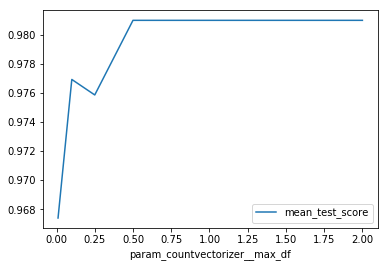

In [14]:
%matplotlib inline

grid = pd.DataFrame(grid_search.cv_results_, dtype = float)
grid.plot.line('param_countvectorizer__max_df', 'mean_test_score') 

In [15]:
params = {'bernoullinb__alpha':[0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]} 
grid_search = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=3, return_train_score=True)
grid_search.fit(df['tokens'], df['sports'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x000001F0C6F41C80>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), p...ary=None)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bernoullinb__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [16]:
grid_search.best_params_

{'bernoullinb__alpha': 1.5}

In [115]:
model_headline = make_pipeline(CountVectorizer(max_df = 0.5, analyzer = identity), BernoulliNB(alpha=1.5))
# this is the final 'model_headline'
score = cross_val_score(model_headline, df['tokens'], df['sports'], cv = 5, n_jobs = -1) 
score.mean(), score.std()

(0.9829333317925923, 0.0005734865316424905)

In [18]:
model = make_pipeline(CountVectorizer(max_df = 0.5, analyzer = identity), MultinomialNB())
score = cross_val_score(model, df['tokens'], df['sports'], cv = 5, n_jobs = -1) 
score.mean(), score.std()

(0.9712667752518638, 0.0013863074881217297)

In [20]:
import re
import numpy as np
from cytoolz import concat
from spacy.lemmatizer import Lemmatizer

In [21]:
def get_terms(doc):
    terms = []
    start = -1
    for i in range(len(doc)):
        if doc[i].pos_ in ['NOUN', 'ADJ']:
            if start == -1:
                start = i
        else:
            if start != -1 and i > start + 1 and doc[i-1].pos_ == 'NOUN' and not doc[i-1].is_stop:
                terms.append(doc[start:i].lower_)
            start = -1
    if start != -1 and i> start + 1 and doc[i-1].pos_ == 'NOUN' and not doc[i-1].is_stop:
        terms.append(doc[start:].lower_)
    return terms

In [55]:
def terminze(text):
    return (get_terms(nlp(text)))

In [57]:
df['terms'] = df['text'].apply(terminze)

In [58]:
df

,date,headline,itemid,text,sports,politics,tokens,terms
1829,1997-01-22,Libya says plane flew to Ghana despite U.N. ban.,325883,Libya said on Wednesday a Libyan plane had flo...,False,False,"[Libya, says, plane, flew, to, Ghana, despite,...","[libyan plane, official delegation, its intern..."
1050,1997-07-06,Dirty laundry to be aired at Senate hearings.,709460,A Senate investigation into political fund-rai...,False,True,"[Dirty, laundry, to, be, aired, at, Senate, he...","[political fund, last year, lengthy airing, di..."
407,1996-09-08,"BA denies report of 10,000 imminent job cuts.",39622,British Airways (BA) denied on Monday a newspa...,False,False,"[BA, denies, report, of, 10,000, imminent, job...","[newspaper report, secret proposals, their job..."
376,1996-12-30,Gulf states could reinstate Israel boycott - p...,281305,Gulf Arab states could reinstate a boycott the...,False,False,"[Gulf, states, could, reinstate, Israel, boyco...","[arab states, peace accords, his comments, ter..."
728,1997-03-06,Volvo Belgian plant to hold Friday stoppage.,425537,Swedish vehicle maker AB Volvo said on Thursda...,False,False,"[Volvo, Belgian, plant, to, hold, Friday, stop...","[swedish vehicle maker, its car plant, whole c..."
1267,1997-07-08,INSTANT VIEW - German unemployment data for June.,715078,Following are economists' reactions to a repor...,False,False,"[INSTANT, VIEW, -, German, unemployment, data,...","[jobless total, large loss, construction jobs,..."
1222,1997-06-20,"Germany, France sign helicopter industrial deal.",676761,French and German officials Friday signed cont...,False,False,"[Germany, ,, France, sign, helicopter, industr...","[german officials, combat helicopter, german d..."
114,1996-11-15,Izetbegovic agrees to sack Minister - U.S..,192047,Bosnia's president bowed to U.S. pressure on F...,False,True,"[Izetbegovic, agrees, to, sack, Minister, -, U...","[senior defense officials, strong ties, massiv..."
2086,1996-09-27,FEATURE - Telecom gets pre-election nerves.,82618,"Two weeks before a general election, New Zeala...",False,True,"[FEATURE, -, Telecom, gets, pre, -, election, ...","[general election, biggest company, telecommun..."
151,1997-03-06,Healthy Yeltsin cheers investors in Russia.,423451,A healthy-looking Russian President Boris Yelt...,False,True,"[Healthy, Yeltsin, cheers, investors, in, Russ...","[foreign investors, all their major concerns, ..."


In [89]:
model = DummyClassifier('most_frequent') 
score = cross_val_score(model, df['terms'], df['sports'], cv = 5, n_jobs = -1)
score.mean()

0.8292000292592625

In [90]:
model = make_pipeline(CountVectorizer(analyzer = identity), BernoulliNB())

In [91]:
score = cross_val_score(model, df['terms'], df['sports'], cv=5, n_jobs=-1)
score.mean(), score.std()

(0.8376668522148354, 0.0018211398728184643)

In [92]:
params = {'countvectorizer__max_df':[0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]} 
grid_search = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=5, return_train_score=True)
grid_search.fit(df['terms'], df['sports'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   42.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x000001F0C6F41C80>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), p...ary=None)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'countvectorizer__max_df': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [93]:
grid_search.best_params_

{'countvectorizer__max_df': 0.01}

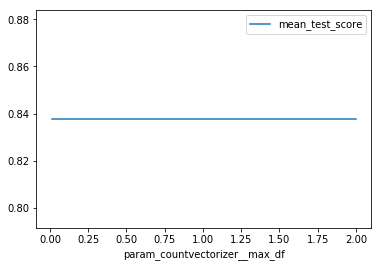

In [94]:
%matplotlib inline

grid = pd.DataFrame(grid_search.cv_results_, dtype = float)
grid.plot.line('param_countvectorizer__max_df', 'mean_test_score') 

In [95]:
model = make_pipeline(CountVectorizer(max_df=0.01, analyzer = identity), BernoulliNB())

In [96]:
score = cross_val_score(model, df['terms'], df['sports'], cv = 5, n_jobs = -1) 
score.mean(), score.std()

(0.8376668522148354, 0.0018211398728184643)

In [97]:
params = {'bernoullinb__alpha':[0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]} 
grid_search = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=3, return_train_score=True)
grid_search.fit(df['terms'], df['sports'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   21.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x000001F0C6F41C80>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.01,
        max_features=None, min_df=1, ngram_range=(1, 1), ...ary=None)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bernoullinb__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [98]:
grid_search.best_params_

{'bernoullinb__alpha': 0.1}

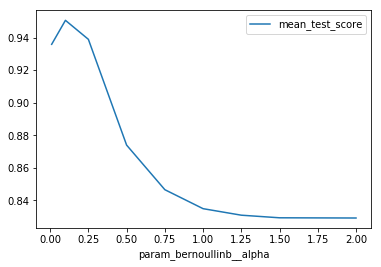

In [99]:
%matplotlib inline

grid = pd.DataFrame(grid_search.cv_results_, dtype = float)
grid.plot.line('param_bernoullinb__alpha', 'mean_test_score') 

In [118]:
model_terms = make_pipeline(CountVectorizer(max_df = 0.01, analyzer = identity), BernoulliNB(alpha=0.1))
score = cross_val_score(model_terms, df['terms'], df['sports'], cv = 5, n_jobs = -1) 
score.mean(), score.std()

(0.9530665737185082, 0.002761359421316086)

In [119]:
model_terms = make_pipeline(CountVectorizer(max_df = 0.01, analyzer = identity), MultinomialNB())
# this is the final 'model_terms'
score = cross_val_score(model_terms, df['terms'], df['sports'], cv = 5, n_jobs = -1) 
score.mean(), score.std()

(0.9616663299777404, 0.0019615803697605114)

In [116]:
model_terms = make_pipeline(CountVectorizer(max_df = 0.01, analyzer = identity), BernoulliNB(alpha=0.1))
score = cross_val_score(model_terms, df['terms'], df['politics'], cv = 5, n_jobs = -1) 
score.mean(), score.std()


(0.8485321864665393, 0.004711299996610379)

In [106]:
_, test = pd.read_msgpack("https://bit.ly/2UcyWOV") #try different data

In [121]:
%time

test['tokens'] = test['text'].apply(tokenize)
model_headline.fit(df['tokens'], df['sports'])
score = cross_val_score(model_headline, df['tokens'], df['politics'], cv = 5, n_jobs = -1) 
model_headline.score(test['tokens'], test['sports'])

Wall time: 0 ns


0.8596

In [122]:
model_headline.fit(df['tokens'], df['politics'])
model_headline.score(test['tokens'], test['politics'])

0.3592

In [123]:
%%time

test['terms'] = test['text'].apply(terminze)
model_terms.fit(df['terms'], df['sports'])
score = cross_val_score(model_terms, df['terms'], df['politics'], cv = 5, n_jobs = -1) 

Wall time: 5min 58s


In [126]:
model_terms.score(test['terms'], test['sports'])

0.543

In [124]:
model_terms.fit(df['terms'], df['politics'])
model_terms.score(test['terms'], test['politics'])

0.869

In [125]:
test

,date,headline,itemid,text,sports,politics,tokens,terms
505,1997-02-04,EU JOBLESS STEADY AT 10.9 PCT IN NOVEMBER.,355001,European Union jobless figures for November sh...,False,False,"[European, Union, jobless, figures, for, Novem...","[jobless figures, previous months, statistics ..."
359,1997-06-25,Space station Mir has lifeboat ready.,686412,The crew of the Russian Mir space station can ...,False,False,"[The, crew, of, the, Russian, Mir, space, stat...","[space station, orbital outpost, space shuttle..."
457,1997-08-04,Flood to cost Polish insurers PLN 1-1.5 bln.,775277,Poland's state-owned insurer PZU estimates it ...,False,False,"[Poland, 's, state, -, owned, insurer, PZU, es...","[flood damages, total payments, polish insurer..."
615,1997-07-01,ETA frees kidnapped Spaniard - police.,700871,The Basque guerrilla group ETA freed a kidnapp...,False,False,"[The, Basque, guerrilla, group, ETA, freed, a,...","[basque guerrilla group, basque businessman, s..."
247,1997-03-27,Taiwan to test-fire two more U.S. Hawk missiles.,471914,Taiwan will test-fire two U.S. Hawk missiles i...,False,False,"[Taiwan, will, test, -, fire, two, U.S., Hawk,...","[military officials, scale manoeuvres, nearby ..."
232,1996-11-12,"Russia, rebels discuss Chechnya reconstruction.",182218,Russian officials and separatist delegates met...,False,True,"[Russian, officials, and, separatist, delegate...","[russian officials, separatist delegates, sout..."
35,1997-05-05,RALLYING-PANIZZI ENDS FIRST DAY AHEAD OF FAVOU...,558947,Frenchman Gilles Panizzi delighted his home fa...,True,False,"[Frenchman, Gilles, Panizzi, delighted, his, h...","[his home fans, wheel drive, opening day, last..."
404,1996-08-26,Lloyd's says most members accept settlement - ...,14950,Lloyd's of London said 75 percent of its world...,False,False,"[Lloyd, 's, of, London, said, 75, percent, of,...","[its worldwide membership, settlement offer, f..."
1313,1997-07-09,GOLF-HAEGGMAN AND CURRY SHOW WAY WITH RECORD R...,715524,Joakim Haeggman of Sweden fired a course-recor...,True,False,"[Joakim, Haeggman, of, Sweden, fired, a, cours...","[first round lead, old record, inaugural event..."
487,1997-03-12,FOCUS - Spain unions table fresh offer to secu...,436858,Spanish unions presented a new proposal to emp...,False,False,"[Spanish, unions, presented, a, new, proposal,...","[spanish unions, new proposal, labour reforms,..."
